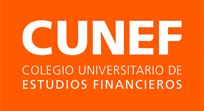

# Máster en Data Science - Machine Learning

# Predicción de fraude mediante el uso de modelos de Machine Learning
##### <font color='dodgerblue' face='Montserrat'>Autor: Rodrigo Fernandez Campos</font>
## DataSet: Bank Account Fraud Dataset Suite (NeurIPS 2022)

# <font size=25><b>Ex notebook 03/04</b></font>

Pruebas feature processing, undersampling, oversampling

* % de oversampling y undersampling
* Eso vs stratified
* Eso vs cada uno x separado (under y over)
* Evaluar en un par de modelos los 4 y ver
* Evaluar en todos los modelos los 2 primeros al menos y ver cual es el mejor!


https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

https://imbalanced-learn.org/stable/combine.html

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://machinelearningmastery.com/data-sampling-methods-for-imbalanced-classification/

In [139]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored, cprint
from sklearn.preprocessing import StandardScaler
import warnings
import sys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#from sklearn.metrics import plot_confusion_matrix

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

import pickle
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## Funciones

In [2]:
sys.path.append('../src/')
import functions_rfc as fr
sys.path.remove('../src/')

### Constantes:
seed=10

## Importación del preprocesamiento anterior

In [11]:
df_fraud_train = pd.read_csv('../data/processed/df_fraud_train_processed.csv')
df_fraud_test = pd.read_csv('../data/processed/df_fraud_test_processed.csv')
df_fraud_train.head()

,Unnamed: 0,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month,fraud_bool
0,0,0.8,0.433984,54,9,30,0.020608,49.172739,0.0,954,5137.541683,2712.051960,4240.496920,2,11,0.0,286,0,0.0,0,1,1,1,1000.0,0,0,14.396148,1,0,0,0,0,0,1,6,0
1,1,0.1,0.712826,-1,97,50,0.024353,-1.091855,1.0,1108,4370.169334,3097.535634,4383.873312,0,6,0.0,132,0,1.0,1,1,28,1,200.0,0,0,4.100053,1,0,0,0,0,0,1,6,0
2,2,0.4,0.222290,32,115,30,0.002837,-1.067640,2.0,266,7168.731474,2865.219877,4207.649556,0,11,0.0,171,0,4.0,0,1,-1,1,200.0,0,0,2.369306,1,0,0,0,0,0,1,5,0
3,3,0.7,0.476667,-1,375,40,0.020157,-0.930885,2.0,962,4761.030105,6249.502233,6013.337906,0,8,0.0,245,1,0.0,0,1,-1,1,1500.0,1,0,31.700024,0,1,0,0,0,1,1,1,0
4,4,0.1,0.506995,11,10,20,0.007662,-0.698526,2.0,874,8823.184279,6315.937497,5653.839202,0,13,3.0,20,0,2.0,0,1,-1,0,200.0,0,0,0.592456,0,1,0,0,0,1,1,2,0


In [12]:
# Elimino la primera columna que repite el Index
df_fraud_train = df_fraud_train.drop('Unnamed: 0',axis=1)
df_fraud_test = df_fraud_test.drop('Unnamed: 0',axis=1)
df_fraud_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month,fraud_bool
0,0.8,0.433984,54,9,30,0.020608,49.172739,0.0,954,5137.541683,2712.051960,4240.496920,2,11,0.0,286,0,0.0,0,1,1,1,1000.0,0,0,14.396148,1,0,0,0,0,0,1,6,0
1,0.1,0.712826,-1,97,50,0.024353,-1.091855,1.0,1108,4370.169334,3097.535634,4383.873312,0,6,0.0,132,0,1.0,1,1,28,1,200.0,0,0,4.100053,1,0,0,0,0,0,1,6,0
2,0.4,0.222290,32,115,30,0.002837,-1.067640,2.0,266,7168.731474,2865.219877,4207.649556,0,11,0.0,171,0,4.0,0,1,-1,1,200.0,0,0,2.369306,1,0,0,0,0,0,1,5,0
3,0.7,0.476667,-1,375,40,0.020157,-0.930885,2.0,962,4761.030105,6249.502233,6013.337906,0,8,0.0,245,1,0.0,0,1,-1,1,1500.0,1,0,31.700024,0,1,0,0,0,1,1,1,0
4,0.1,0.506995,11,10,20,0.007662,-0.698526,2.0,874,8823.184279,6315.937497,5653.839202,0,13,3.0,20,0,2.0,0,1,-1,0,200.0,0,0,0.592456,0,1,0,0,0,1,1,2,0


In [13]:
# Descripción de los datos:
var_description = pd.read_excel('../data/interim/variables_description.xlsx')
var_description.head()

,Variable,Type,Description,Possible Values / Range,Missings
0,fraud_bool,binary,TARGET - If the application is fraudulent or not.,[1 0],NaN
1,income,numeric,Annual income of the applicant (in decile form).,[0.1 to 0.9],NaN
2,name_email_similarity,numeric,Metric of similarity between email and applic...,[0.00 to 1.00],NaN
3,prev_address_months_count,numeric,Number of months in previous registered addre...,[-1.00 to 383.00],-1
4,current_address_months_count,numeric,Months in currently registered address of the...,[-1.00 to 429.00],-1


In [14]:
X_train = df_fraud_train.drop('fraud_bool', axis=1)
y_train = df_fraud_train['fraud_bool']
X_test = df_fraud_test.drop('fraud_bool', axis=1)
y_test = df_fraud_test['fraud_bool']

X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month
0,0.8,0.433984,54,9,30,0.020608,49.172739,0.0,954,5137.541683,2712.051960,4240.496920,2,11,0.0,286,0,0.0,0,1,1,1,1000.0,0,0,14.396148,1,0,0,0,0,0,1,6
1,0.1,0.712826,-1,97,50,0.024353,-1.091855,1.0,1108,4370.169334,3097.535634,4383.873312,0,6,0.0,132,0,1.0,1,1,28,1,200.0,0,0,4.100053,1,0,0,0,0,0,1,6
2,0.4,0.222290,32,115,30,0.002837,-1.067640,2.0,266,7168.731474,2865.219877,4207.649556,0,11,0.0,171,0,4.0,0,1,-1,1,200.0,0,0,2.369306,1,0,0,0,0,0,1,5
3,0.7,0.476667,-1,375,40,0.020157,-0.930885,2.0,962,4761.030105,6249.502233,6013.337906,0,8,0.0,245,1,0.0,0,1,-1,1,1500.0,1,0,31.700024,0,1,0,0,0,1,1,1
4,0.1,0.506995,11,10,20,0.007662,-0.698526,2.0,874,8823.184279,6315.937497,5653.839202,0,13,3.0,20,0,2.0,0,1,-1,0,200.0,0,0,0.592456,0,1,0,0,0,1,1,2


## Set de Validación

A la hora de realizar una comparativa de modelos, voy a ejecutar un pipeline que corra cada uno de ellos en su formato básico (sin configuración óptima de hiperparámetros) para elegir el (o los) que se aplicarán finalmente para la predicción definitiva. Para ello, no puedo realizar esta medición entre modelos utilizando el set de test, debido a que esto sería un importante error. Recordemos que el test debe permanecer inmaculado hasta su uso por única vez en el mismo testeo del modelo final.

Es por ello que procedo a dividir el dataset de train en set de train y de validation, también de manera estratificada. De esta manera podré medir los modelos de prueba sin contaminar el set de test.


In [15]:
X_train, X_val, y_train, y_val = train_test_split(df_fraud_train.drop('fraud_bool',axis=1)
                                                    ,df_fraud_train['fraud_bool']
                                                    ,stratify=df_fraud_train['fraud_bool']
                                                    ,test_size=0.3
                                                    ,random_state=seed)

In [16]:
X_train.shape, X_test.shape, X_val.shape

((490000, 34), (300000, 34), (210000, 34))

## Escalado de variables

Realizo un escalado porque uno de los métodos de Featuring Selection será realizado mediante un modelo de Regresión

In [17]:
scaler = StandardScaler()
model_scaled = scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train_scaled.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month
599278,-0.906378,-1.141368,-0.107470,-0.753237,-0.306349,-0.187361,-0.480608,-0.239490,-0.526812,-0.467579,0.490529,1.239599,4.292476,0.496493,0.308335,0.259751,0.940482,0.180225,-0.846629,0.352074,-0.813561,-0.535305,-0.030835,-0.161577,-0.083862,-0.337002,-0.721847,1.417951,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.129402
499849,1.160536,1.227288,-0.402094,0.253942,0.524904,-0.188845,-0.506226,0.793958,1.384972,-0.322429,-0.786542,-0.595162,-0.400956,0.098949,-0.473747,0.302832,-1.063284,-0.607893,1.181155,0.352074,-0.978612,1.868093,-0.646885,-0.161577,-0.083862,0.428755,-0.721847,-0.705243,-0.598906,4.187688,-0.085935,0.857227,-0.101765,0.775534
345337,-1.595349,1.292729,0.209817,-0.787187,-1.137602,-0.189010,-0.508535,-0.239490,0.148930,0.407826,0.291226,-0.242573,-0.396598,1.689126,-0.473747,0.460797,-1.063284,-0.607893,1.181155,0.352074,-0.978612,-0.535305,-0.010300,-0.161577,-0.083862,-0.332120,1.385334,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.129402
571314,-1.595349,-0.058074,-0.402094,-0.300572,0.524904,-0.189629,-0.503390,0.793958,-0.220290,1.642870,1.749420,0.473835,-0.400956,-0.298595,-0.473747,-0.788563,0.940482,-0.607893,-0.846629,0.352074,-0.978612,-0.535305,-0.646885,-0.161577,-0.083862,2.296500,1.385334,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-1.034339
379586,-0.561893,-0.499498,-0.130133,-0.877720,-0.306349,-0.186727,-0.476766,1.827405,1.479517,-0.587615,1.277493,1.158247,-0.322514,1.291582,-0.473747,0.776728,0.940482,0.180225,-0.846629,0.352074,-0.813561,-0.535305,2.022667,-0.161577,-0.083862,-0.130286,1.385334,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.581871


# Featuring Selection:

Para llevar a cabo este apartado utilizaré todos los datos que tengo disponibles. Es decir, NO separaré en train, test y val. Esto debido a que NO voy a estimar nada con estos modelos, sino que simplemente deseo conocer las variables que son relevantes y las que no.

In [30]:
X = pd.concat([X_train,X_val,X_test])
y = pd.concat([y_train,y_val,y_test])
X.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month
599278,0.3,0.164202,12,20,30,0.014626,-1.047699,1.0,1043,4260.759042,5496.030982,5997.273703,2154,12,1.0,149,1,2.0,0,1,1,0,500.0,0,0,4.839120,0,1,0,0,0,0,1,3
499849,0.9,0.848983,-1,109,40,0.006597,-1.566874,2.0,2964,4697.401403,3608.231408,4310.932705,0,10,0.0,152,0,1.0,1,1,-1,1,200.0,0,0,11.010277,0,0,0,1,0,1,1,5
345337,0.1,0.867902,26,17,20,0.005707,-1.613666,1.0,1722,6894.161402,5201.415087,4635.000046,2,18,0.0,163,0,1.0,1,1,-1,0,510.0,0,0,4.878469,1,0,0,0,0,0,1,3
571314,0.1,0.477383,-1,60,40,0.002358,-1.509390,2.0,1351,10609.431835,7356.955806,5293.455388,0,8,0.0,76,1,1.0,0,1,-1,0,200.0,0,0,26.062248,1,0,0,0,0,0,1,1
379586,0.4,0.349767,11,9,30,0.018052,-0.969820,3.0,3059,3899.666316,6659.340417,5922.503266,36,16,0.0,185,1,2.0,0,1,1,0,1500.0,0,0,6.505027,1,0,0,0,0,0,1,2


## Trees

En este caso, incluiré una variable random que me ayude a delimitar que variables son más o menos importantes

In [59]:
np.random.seed(seed)
X['fs_random'] = np.random.randint(0,10000,X.shape[0])

In [60]:
X.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month,fs_random
599278,0.3,0.164202,12,20,30,0.014626,-1.047699,1.0,1043,4260.759042,5496.030982,5997.273703,2154,12,1.0,149,1,2.0,0,1,1,0,500.0,0,0,4.839120,0,1,0,0,0,0,1,3,1289
499849,0.9,0.848983,-1,109,40,0.006597,-1.566874,2.0,2964,4697.401403,3608.231408,4310.932705,0,10,0.0,152,0,1.0,1,1,-1,1,200.0,0,0,11.010277,0,0,0,1,0,1,1,5,7293
345337,0.1,0.867902,26,17,20,0.005707,-1.613666,1.0,1722,6894.161402,5201.415087,4635.000046,2,18,0.0,163,0,1.0,1,1,-1,0,510.0,0,0,4.878469,1,0,0,0,0,0,1,3,1344
571314,0.1,0.477383,-1,60,40,0.002358,-1.509390,2.0,1351,10609.431835,7356.955806,5293.455388,0,8,0.0,76,1,1.0,0,1,-1,0,200.0,0,0,26.062248,1,0,0,0,0,0,1,1,7291
379586,0.4,0.349767,11,9,30,0.018052,-0.969820,3.0,3059,3899.666316,6659.340417,5922.503266,36,16,0.0,185,1,2.0,0,1,1,0,1500.0,0,0,6.505027,1,0,0,0,0,0,1,2,9372


In [66]:
clf = RandomForestClassifier(n_estimators=500
                             ,criterion='gini'
                             ,max_depth=5 # nunca más de 14. Elegí 5 porque tardaba demasiado con más...
                             ,random_state=seed)

clf.fit(X, y)

RandomForestClassifier(max_depth=4, n_estimators=500, random_state=10)

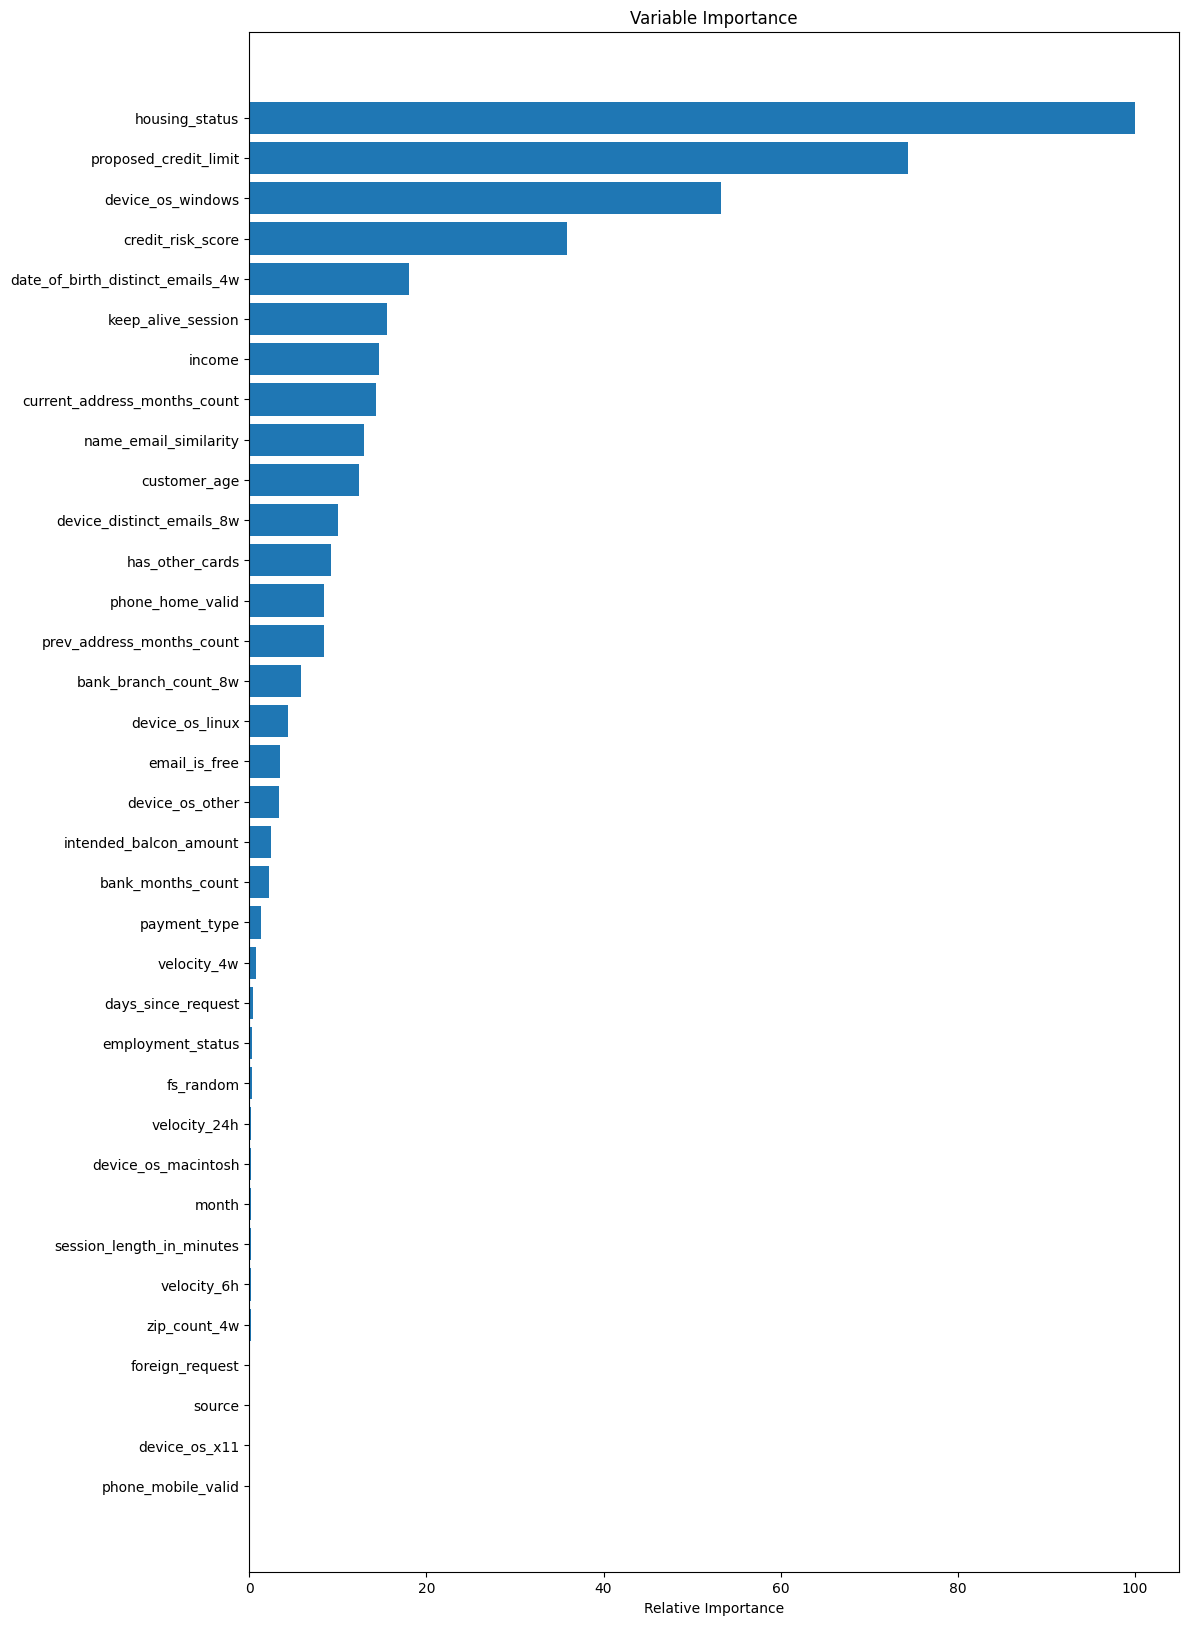

In [67]:
feature_importance = clf.feature_importances_ # Si uso XGBoost, determinar Method=Gain (SI ES SPLIT VA A ELIMINARME LA RANDOM) --> VARIABLE RANDOM DEL 0 AL 10000
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 20))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Regresiones con Regularización

Antes de llevar a cabo estos modelos, procederé a eliminar una de las variables creadas en el OHE, ya que no son n-1 categorías, sino que existe exatamente una variable por categoría y esto podría conllevar a que haya duplicación de información

### Ridge

In [87]:
X_scaled = pd.concat([X_train_scaled, X_val_scaled, X_test_scaled])
X_scaled = X_scaled.drop('device_os_other', axis=1)
X_scaled.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month
599278,-0.906378,-1.141368,-0.107470,-0.753237,-0.306349,-0.187361,-0.480608,-0.239490,-0.526812,-0.467579,0.490529,1.239599,4.292476,0.496493,0.308335,0.259751,0.940482,0.180225,-0.846629,0.352074,-0.813561,-0.535305,-0.030835,-0.161577,-0.083862,-0.337002,1.417951,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.129402
499849,1.160536,1.227288,-0.402094,0.253942,0.524904,-0.188845,-0.506226,0.793958,1.384972,-0.322429,-0.786542,-0.595162,-0.400956,0.098949,-0.473747,0.302832,-1.063284,-0.607893,1.181155,0.352074,-0.978612,1.868093,-0.646885,-0.161577,-0.083862,0.428755,-0.705243,-0.598906,4.187688,-0.085935,0.857227,-0.101765,0.775534
345337,-1.595349,1.292729,0.209817,-0.787187,-1.137602,-0.189010,-0.508535,-0.239490,0.148930,0.407826,0.291226,-0.242573,-0.396598,1.689126,-0.473747,0.460797,-1.063284,-0.607893,1.181155,0.352074,-0.978612,-0.535305,-0.010300,-0.161577,-0.083862,-0.332120,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.129402
571314,-1.595349,-0.058074,-0.402094,-0.300572,0.524904,-0.189629,-0.503390,0.793958,-0.220290,1.642870,1.749420,0.473835,-0.400956,-0.298595,-0.473747,-0.788563,0.940482,-0.607893,-0.846629,0.352074,-0.978612,-0.535305,-0.646885,-0.161577,-0.083862,2.296500,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-1.034339
379586,-0.561893,-0.499498,-0.130133,-0.877720,-0.306349,-0.186727,-0.476766,1.827405,1.479517,-0.587615,1.277493,1.158247,-0.322514,1.291582,-0.473747,0.776728,0.940482,0.180225,-0.846629,0.352074,-0.813561,-0.535305,2.022667,-0.161577,-0.083862,-0.130286,-0.705243,-0.598906,-0.238795,-0.085935,-1.166552,-0.101765,-0.581871


In [88]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.075)
sel_ridge.fit(X_scaled, y)
# Si aplicas transform(X_train_scaled, y_train) y transform(X_test_scaled, y_test), filtra las variables seleccionadas 

SelectFromModel(estimator=LogisticRegression(C=1), threshold=0.075)

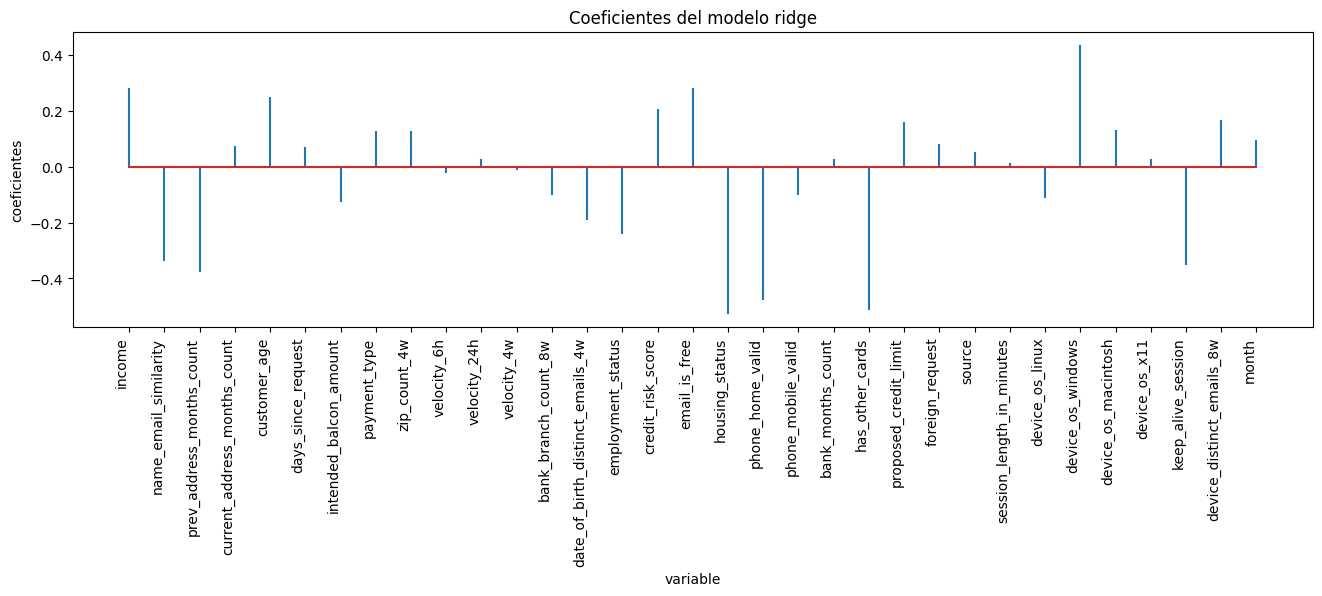

In [89]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_scaled.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [90]:
sel_ridge.get_support()
selected_feat = X_scaled.columns[sel_ridge.get_support()]
selected_feat

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'customer_age', 'intended_balcon_amount', 'payment_type',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'device_os_linux',
       'device_os_windows', 'device_os_macintosh', 'keep_alive_session',
       'device_distinct_emails_8w', 'month'],
      dtype='object')

In [91]:
sel_ridge.get_support()

array([ True,  True,  True, False,  True, False,  True,  True,  True,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True])

In [92]:
print('total features: {}'.format((X_train_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 34
selected features: 24


In [93]:
# eliminadas:
X_scaled.columns[~sel_ridge.get_support()]

Index(['current_address_months_count', 'days_since_request', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_months_count', 'source',
       'session_length_in_minutes', 'device_os_x11'],
      dtype='object')

Bastante de acuerdo, ver que hacer con foreign_request y velocitys

In [78]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'), threshold = 0.075)
sel_lasso.fit(X_scaled, y)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.075)

In [79]:
sel_lasso.get_support()
selected_feat_lasso = X_scaled.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['income', 'name_email_similarity', 'prev_address_months_count',
       'customer_age', 'intended_balcon_amount', 'payment_type',
       'zip_count_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'device_os_linux',
       'device_os_windows', 'device_os_macintosh', 'keep_alive_session',
       'device_distinct_emails_8w', 'month'],
      dtype='object')

In [80]:
print('total features: {}'.format((X_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 34
selected features: 24


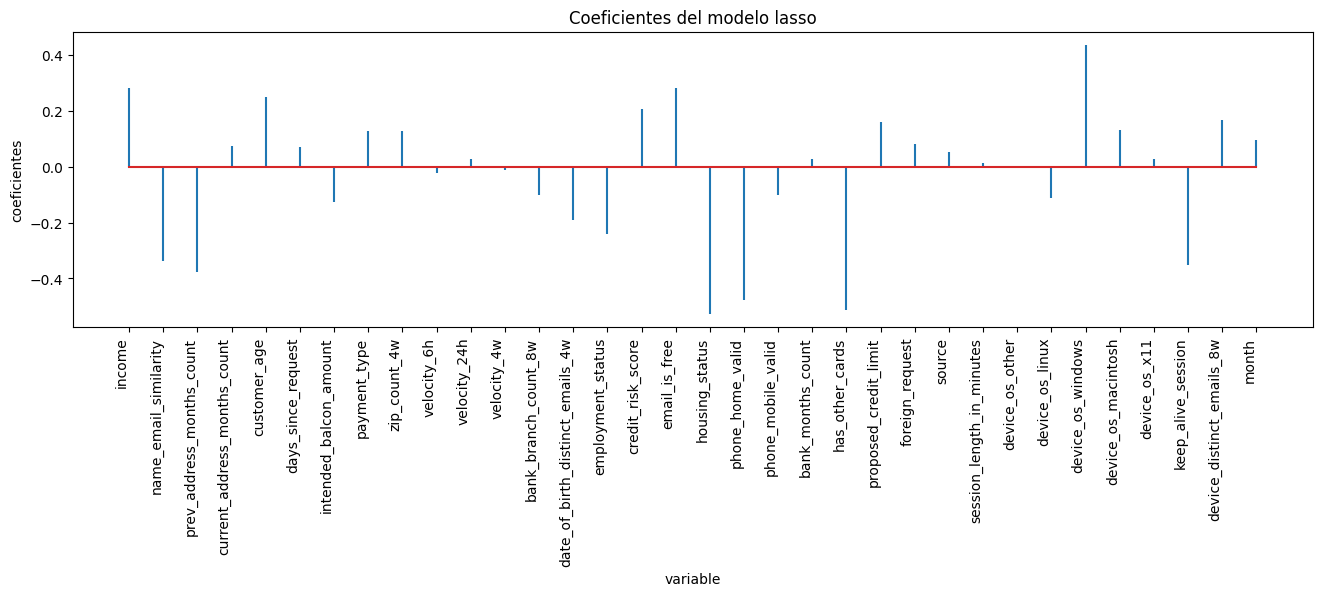

In [81]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_scaled.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo lasso');

In [82]:
# eliminadas:
X_scaled.columns[~sel_lasso.get_support()]

Index(['current_address_months_count', 'days_since_request', 'velocity_6h',
       'velocity_24h', 'velocity_4w', 'bank_months_count', 'source',
       'session_length_in_minutes', 'device_os_other', 'device_os_x11'],
      dtype='object')

Ok, similar a las otras dos clasificaciones.

## Reducción de dimensionalidad

He decidido no ejecutar el método **T-SNE** de reducción de dimensiones debido a que he intentado correrlo un buen rato y noto que requiere muchos recursos de mi ordenador, además de que no es el modelo final a ejecutar, sino simplemente un añadido para nuestra clasificación. La capacidad de computo que requiere este método aumenta de manera cuadrática con la cantidad de instancias (medio millón en caso del train), por lo que puede ser demasiado para lo que estoy necesitando actualmente.

Al no ejecutar dicho modelo, probaré hacer lo mismo pero con PCA. Reduciré a 2 dimensiones, graficaré y agregaré la clusterización a mi dataser como nueva columna.

In [85]:
#%%time
#tsne = TSNE(n_components=2)
#tsne.fit(X_train)

In [128]:
pca = PCA(n_components=2)
pca.fit(X_train_scaled.reset_index(drop=True)) # al convertirse en un array de numpy, pierden el index. luego al y también le reseteo el index para que queden en orden
pca_array = pca.transform(X_train_scaled)

In [142]:
pca_array

array([[ 1.08505475, -0.28416105],
       [-1.45600706,  0.20850334],
       [ 0.64958237, -1.02027753],
       ...,
       [-0.9781789 , -0.06619955],
       [-1.3234282 ,  0.47336333],
       [-1.38505337, -0.91666275]])

In [163]:
pca.components_

array([[-0.15632391,  0.02973477,  0.02711443, -0.03896449, -0.14151459,
         0.04671742,  0.03850584, -0.00954183,  0.2353204 ,  0.33778648,
         0.39622122,  0.45952624,  0.01642371,  0.25007801,  0.03724151,
        -0.24518155,  0.0616051 ,  0.15914011, -0.09640585,  0.02416179,
         0.03448487, -0.08496216, -0.10140455,  0.01376703, -0.01185966,
         0.07625298, -0.00180891,  0.05833888, -0.05605851, -0.00819804,
        -0.00065668,  0.03241739,  0.03952409, -0.46220989],
       [ 0.10250107,  0.04860853, -0.14877928,  0.28065912,  0.40222736,
        -0.0933536 ,  0.128261  , -0.13518673,  0.08952583,  0.13731044,
         0.18483574,  0.21352663,  0.11737479, -0.22670232,  0.02601022,
         0.28331945, -0.02715213, -0.26080993,  0.20865449, -0.18775721,
         0.09720505,  0.17563423,  0.35887771,  0.01500785,  0.00316018,
         0.02493522, -0.11460912, -0.0633244 ,  0.20108926, -0.02831253,
         0.02311052, -0.07413345,  0.02977756, -0.21321002]])

In [188]:
components = pca.components_
component_names = [f'Component {i+1}' for i in range(2)]
df_components = pd.DataFrame(components.T, columns=component_names, index=X_train_scaled.columns.values)

def highlight_max(s, props=''):
    return np.where(abs(s) == np.nanmax(abs(s.values)), props, '')
df_components.style.apply(highlight_max, props='color:black;background-color:deepskyblue', axis=1)

,Component 1,Component 2
income,-0.156324,0.102501
name_email_similarity,0.029735,0.048609
prev_address_months_count,0.027114,-0.148779
current_address_months_count,-0.038964,0.280659
customer_age,-0.141515,0.402227
days_since_request,0.046717,-0.093354
intended_balcon_amount,0.038506,0.128261
payment_type,-0.009542,-0.135187
zip_count_4w,0.235320,0.089526
velocity_6h,0.337786,0.137310


In [198]:
df_components['Winner'] = df_components.abs().idxmax(axis=1)
df_components

,Component 1,Component 2,Winner
income,-0.156324,0.102501,Component 1
name_email_similarity,0.029735,0.048609,Component 2
prev_address_months_count,0.027114,-0.148779,Component 2
current_address_months_count,-0.038964,0.280659,Component 2
customer_age,-0.141515,0.402227,Component 2
days_since_request,0.046717,-0.093354,Component 2
intended_balcon_amount,0.038506,0.128261,Component 2
payment_type,-0.009542,-0.135187,Component 2
zip_count_4w,0.235320,0.089526,Component 1
velocity_6h,0.337786,0.137310,Component 1


In [205]:
df_components[df_components.Winner == 'Component 1'].index

Index(['income', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'email_is_free', 'source', 'session_length_in_minutes',
       'device_distinct_emails_8w', 'month'],
      dtype='object')

In [206]:
df_components[df_components.Winner == 'Component 2'].index

Index(['name_email_similarity', 'prev_address_months_count',
       'current_address_months_count', 'customer_age', 'days_since_request',
       'intended_balcon_amount', 'payment_type', 'bank_branch_count_8w',
       'credit_risk_score', 'housing_status', 'phone_home_valid',
       'phone_mobile_valid', 'bank_months_count', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'device_os_other',
       'device_os_linux', 'device_os_windows', 'device_os_macintosh',
       'device_os_x11', 'keep_alive_session'],
      dtype='object')

In [133]:
principalDf = pd.DataFrame(data=pca_array, columns=['PC 1', 'PC 2'])
pcaDf = pd.concat([principalDf, y_train.reset_index(drop=True)], axis = 1)
pcaDf.head()

,PC 1,PC 2,fraud_bool
0,1.085055,-0.284161,0
1,-1.456007,0.208503,0
2,0.649582,-1.020278,0
3,2.377535,-0.120923,0
4,1.597140,-0.101250,0


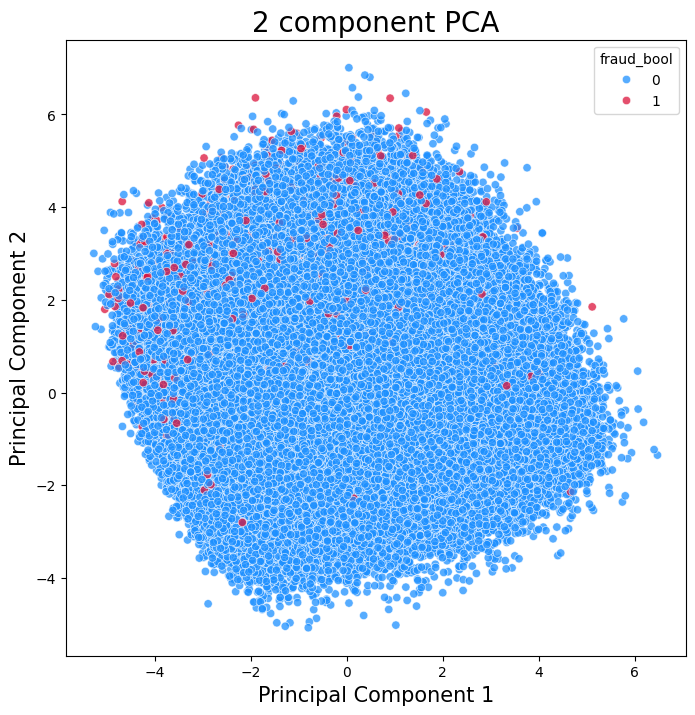

In [134]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=pcaDf, x='PC 1', y='PC 2', hue='fraud_bool', alpha=0.75, palette=['dodgerblue','crimson'])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
plt.show()

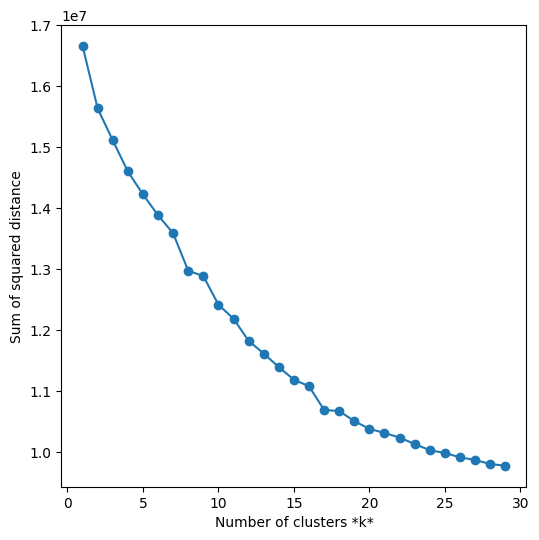

In [141]:
sse = []
list_k = list(range(1, 30))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_train_scaled)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(f'Number of clusters {k}')
plt.ylabel('Sum of squared distance');

In [102]:
dump(clf, '../models/rf_base_featuring_selection.joblib')

['../models/rf_base_featuring_selection.joblib']

In [45]:
#loaded_model = load('../models/rf_base_featuring_selection.joblib')

In [46]:
with open('../models/rf_base_featuring_selection.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [48]:
#with open('../models/rf_base_featuring_selection.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)

In [49]:
dump(sel_lasso, '../models/lasso_base_featuring_selection.joblib')

['../models/lasso_base_featuring_selection.joblib']

In [50]:
with open('../models/lasso_base_featuring_selection.pkl', 'wb') as file:
    pickle.dump(sel_lasso, file)

Luego de realizar ambos modelos para seleccionar variables, he decidido recortar en el orden del Random Forest, lo cual
a su vez se condice con las variables a eliminar según Lasso con un threshold del 0.075. Excepto el foreign_request. Que parece una variable sensible
a cambios en el target por lo que vimos en el EDA, así que por las dudas la mantengo.

Las mismas además se condicen con las variables más cercanas a 0 en las matrices de correlación

# OJO! NO SE SI PUEDO ELIMINAR ALGUNAS COLS DEL OHE!!! REVISAR Y EN TODO CASO COMENTAR!

In [67]:
vars_recortadas = X_train_scaled.columns[~sel_lasso.get_support()].values

In [94]:
X_train_cut = X_train.drop(vars_recortadas, axis=1)
X_test_cut = X_test.drop(vars_recortadas, axis=1)
X_train_samp_cut = X_train_pipe_samp.drop(vars_recortadas, axis=1)

In [95]:
X_train_cut.shape, X_test_cut.shape, X_train_samp_cut.shape

((700000, 24), (300000, 24), (519209, 24))

# Unsersampling + Oversampling

Investigando en internet me he topado con una técnica que me parece interesante, que es una combinación proporcional de undersampling y oversampling. He decidido probarlo mediante la aplicación de un Pipeline en donde se aplican secuencialmente las técnicas.

Me parece una aplicación acertada para casos como el de este dataset en donde los datos están extremadamente desbalanceados, al punto de que un undersampling aplicado directamente eliminaría una cantidad demasiado alta de información, mientras que un oversampling podría generar un sesgo por la cantidad enorme de datos sintéticos a generar. Es por eso que un acercamiento entre ambos parece una solución interesante, al menos sobre el papel.

Existen dentro de Imbalanced-Learning de SKL dos funciones con una combinación interna de oversampling y undersampling, pero al probarlas no parecen estar optimizadas y el costo computacional que me requieren es demasiado alto, por eso generaré y aplicaré mi propio Pipeline manualmente.

Entonces, para lidiar con el desbalanceo terminaré aplicando:

1. Split estatificado (SE) --> (Notebook 02)
2. RandomUnderSampling
3. SMOTE OverSampling
4. SE + Pipeline con sampling mix --> (SMOTE OverSampling + Random UnderSampling)


In [7]:
# El tamaño y distribución actual del DataSet de train son los siguientes:
X_train.shape,y_train.value_counts(),y_train.value_counts(normalize=True)

((700000, 34),
 fraud_bool
 0    692280
 1      7720
 Name: count, dtype: int64,
 fraud_bool
 0    0.988971
 1    0.011029
 Name: proportion, dtype: float64)

In [8]:
# Undersampling:
undersamp = RandomUnderSampler(sampling_strategy=0.6666667, random_state=seed) # Voy a buscar una proporción de aprox 60%-40% 
X_train_under, y_train_under = undersamp.fit_resample(X_train, y_train)

In [9]:
X_train_under.shape,y_train_under.value_counts(),y_train_under.value_counts(normalize=True)

((19299, 34),
 fraud_bool
 0    11579
 1     7720
 Name: count, dtype: int64,
 fraud_bool
 0    0.599979
 1    0.400021
 Name: proportion, dtype: float64)

In [10]:
1 - X_train_under.shape[0] / X_train.shape[0]

0.97243

Logramos el cometido, el dataset está balanceado, pero solo nos quedamos con 19k datos, es decir que perdimos el 97% de nuestro dataset, 
algo que al menos a mi no me parece muy razonable

In [11]:
# Oversampling:
oversamp = SMOTE(sampling_strategy=0.666667, random_state=seed)
X_train_over, y_train_over = oversamp.fit_resample(X_train, y_train)

In [12]:
X_train_over.shape,y_train_over.value_counts(),y_train_over.value_counts(normalize=True)

((1153800, 34),
 fraud_bool
 0    692280
 1    461520
 Name: count, dtype: int64,
 fraud_bool
 0    0.6
 1    0.4
 Name: proportion, dtype: float64)

In [13]:
y_train_over.value_counts()[1] - y_train.value_counts()[1]

453800

In [14]:
(y_train_over.value_counts()[1] - y_train.value_counts()[1]) / y_train.size

0.6482857142857142

Con este método generamos 453k nuevos registros, es decir que agrandamos nuestro dataset de manera sintética un 65%, lo cual parece un poco excesivo

In [15]:
# SE + Pipeline manual (SMOTE OverSampling + UnderSampling):
over = SMOTE(sampling_strategy=0.3, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.6666667, random_state=seed) # Voy a buscar una proporción de aprox 60%-40%
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_pipe_samp, y_train_pipe_samp = pipeline.fit_resample(X_train, y_train)

In [16]:
X_train_pipe_samp.shape,y_train_pipe_samp.value_counts(),y_train_pipe_samp.value_counts(normalize=True)

((519209, 34),
 fraud_bool
 0    311525
 1    207684
 Name: count, dtype: int64,
 fraud_bool
 0    0.599999
 1    0.400001
 Name: proportion, dtype: float64)

Vemos que de esta manera reducimos a poco más de la mitad los datos originales de train y la cantidad de datos a generar sintéticamente

El tamaño del dataset no es minúsculo ni se expandió de manera tan abrupta, se disminuyó un poco, de 700k registros a 519k, de los cuales aprox 200k son sintéticos.

Por supuesto que nunca vamos a llegar a una solución perfecta, pero esta pareciese ser la más razonable por el momento, aunque sin haberla medido. La hora de la verdad llegará en los próximos notebooks cuando comencemos a probar los modelos.

In [17]:
X_train_pipe_samp.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,employment_status,credit_risk_score,email_is_free,housing_status,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os_other,device_os_linux,device_os_windows,device_os_macintosh,device_os_x11,keep_alive_session,device_distinct_emails_8w,month
552289,0.9,0.298806,-1,180,20,0.009536,-0.875978,1.0,819,9797.468244,6302.576793,5945.947559,2,11,0.0,197,0,0.0,1,0,28,1,1500.0,0,0,4.961887,1,0,0,0,0,0,1,1
45490,0.9,0.146466,351,5,40,0.039689,-0.918274,1.0,820,7869.931923,7153.224414,5169.981337,8,9,0.0,40,0,1.0,1,1,1,0,200.0,0,0,5.241980,0,1,0,0,0,0,1,2
204917,0.2,0.917009,-1,113,40,0.015644,-1.032241,2.0,3476,3255.239054,3139.692631,4706.497837,0,6,0.0,135,0,0.0,0,1,-1,0,500.0,0,0,8.195009,0,1,0,0,0,0,1,3
319889,0.4,0.446157,38,18,30,0.006393,50.582683,0.0,1957,2436.602861,4026.769518,5584.932003,7,20,0.0,135,0,4.0,0,1,19,0,1500.0,0,0,4.524850,0,0,1,0,0,1,1,2
525402,0.8,0.991005,11,6,40,0.006078,-0.619936,1.0,558,3799.687851,3685.366676,4434.986066,7,10,0.0,187,0,0.0,0,1,28,0,1000.0,0,0,5.737804,0,1,0,0,0,0,1,4


In [97]:
# restauro el index:
X_train_pipe_samp = X_train_pipe_samp.reset_index(drop=True)
y_train_pipe_samp = y_train_pipe_samp.reset_index(drop=True)

## Exporto mis datasets para usar en el próximo notebook

Para no generar ficheros de más, concateno los train y test en un mismo DF y luego al importarlos los volveré a separar

In [99]:
pd.concat([X_train,y_train], axis=1).to_csv('../data/processed/df_train_ready_to_model.csv', index=False) # luego separaré nuevamente en X e y a la hora de modelar.
pd.concat([X_test,y_test], axis=1).to_csv('../data/processed/df_test_ready_to_model.csv', index=False) # lo mismo aplica para el test, se separará luego para no guardar dos csv separados.

X_train_cut.to_csv('../data/processed/X_train_cut_ready_to_model.csv', index=False) # recortado 
X_test_cut.to_csv('../data/processed/X_test_cut_ready_to_model.csv', index=False)

pd.concat([X_train_samp_cut,y_train_pipe_samp], axis=1).to_csv('../data/processed/df_train_sampled_ready_to_model.csv', index=False) # sampled